In [24]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [26]:
df = pd.read_parquet('./data/fhv_tripdata_2021-01.parquet')

# Stats

## Question 1: Number of records in Jan 2021 FHV data

In [28]:
df.shape

(1154112, 7)

## Question 2: Average duration in Jan 2021 FHV

In [30]:
df['duration'] = df.dropOff_datetime - df.pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [32]:
df.duration.mean()

19.167224093791006

## Question 3: Fraction of missing values

In [34]:
sum(df["PUlocationID"].isna() & df["DOlocationID"].isna()) / df.shape[0]

0.13064503271779515

In [36]:
(sum(df["PUlocationID"].isna()) + sum(df["DOlocationID"].isna())) / (df.shape[0] * 2)

0.48543252301336437

In [38]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
dispatching_base_num,dispatching_base_num,0.000000
pickup_datetime,pickup_datetime,0.000000
dropOff_datetime,dropOff_datetime,0.000000
PUlocationID,PUlocationID,83.030676
DOlocationID,DOlocationID,14.055828
SR_Flag,SR_Flag,100.000000
Affiliated_base_number,Affiliated_base_number,0.076682
duration,duration,0.000000


In [22]:
sum(df.isnull().sum()) / (len(df) * 4)

0.49290796733765874

# Filtering

In [40]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PUlocationID', 'DOlocationID']
# numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

# Model

In [42]:
train_dicts = df[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


10.528519403306927

## Question 4: Dimensionality after OHE

In [43]:
X_train.shape

(1109826, 525)

## Question 5: RMSE on train

- RMSE: 10.52

C:\Users\obalo\AppData\Local\Temp\ipykernel_34984\1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
C:\Users\obalo\AppData\Local\Temp\ipykernel_34984\1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


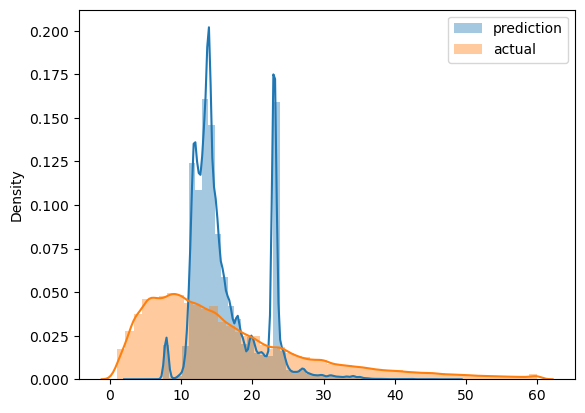

In [46]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [50]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PUlocationID', 'DOlocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [52]:
df_train = read_dataframe("./data/fhv_tripdata_2021-01.parquet")
df_val = read_dataframe('./data/fhv_tripdata_2021-02.parquet')

In [53]:
len(df_train), len(df_val)

(1109826, 990113)

In [56]:
df_train['PU_DO'] = df_train['PUlocationID'] + '_' + df_train['DOlocationID']
df_val['PU_DO'] = df_val['PUlocationID'] + '_' + df_val['DOlocationID']

In [58]:
categorical = ['PU_DO']

dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [60]:
X_train.shape

(1109826, 19683)

In [62]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

In [ ]:
lr = Lasso()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

In [5]:
def vectorize(df, train=False):
    categorical = ['PUlocationID', 'DOlocationID']
    dicts = df[categorical].to_dict(orient='records')

    if train:
        dv = DictVectorizer()
        X = dv.fit_transform(dicts)
    
        with open('models/dv.bin', 'wb') as f_out:
            pickle.dump(dv, f_out)
    else:
        with open('models/dv.bin', 'rb') as f_in:
            dv = pickle.load(f_in)
        X = dv.transform(dicts)
    
    target = 'duration'
    y = df[target].values
    
    return X, y

In [59]:
X_train, y_train = vectorize(df_train, train=True)
X_val, y_val = vectorize(df_val)

In [64]:
def model(X_train, y_train):
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    with open('models/lin_reg.bin', 'wb') as f_out:
        pickle.dump(lr, f_out)
        
    return lr

In [65]:
lr = model(X_train, y_train)

In [67]:
def validation(model, X, y):
    y_pred = model.predict(X)

    print("RMSE:", mean_squared_error(y, y_pred, squared=False))

In [63]:
print("Train")
validation(lr, X_train, y_train)
print("Val")
validation(lr, X_val, y_val)

Train


NameError: name 'validation' is not defined